In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Set seaborn style
sns.set(style="whitegrid")

In [3]:
# Load CSV files 
trader_df = pd.read_csv(r"C:\Users\ASUS\Downloads\historical_data.csv")
sentiment_df = pd.read_csv(r"C:\Users\ASUS\Downloads\fear_greed_index.csv")

In [8]:
trader_df.columns

Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')

In [10]:
sentiment_df.columns

Index(['timestamp', 'value', 'classification', 'date'], dtype='object')

In [19]:
# Find the right columns
trader_time = [col for col in trader_df.columns if 'time' in col.lower() or 'timestamp' in col.lower()][0]
sentiment_date = [col for col in sentiment_df.columns if 'date' in col.lower()][0]
sentiment_class = [col for col in sentiment_df.columns if 'class' in col.lower()][0]

In [20]:
# Convert time columns to date format
trader_df[trader_time] = pd.to_datetime(trader_df[trader_time])
trader_df['date'] = trader_df[trader_time].dt.date

In [21]:
sentiment_df[sentiment_date] = pd.to_datetime(sentiment_df[sentiment_date])
sentiment_df['date'] = sentiment_df[sentiment_date].dt.date

In [23]:
# Merge both datasets on 'date'
merged_df = pd.merge(trader_df, sentiment_df[['date', sentiment_class]], on = 'date', how='inner')
merged_df.rename(columns={sentiment_class:'Sentiment'},inplace=True)

In [24]:
# Clean the data (removed bad values)
merged_df = merged_df.replace([np.inf, -np.inf], np.nan).dropna()

In [28]:
# Calculate ROI (profit based on size and price)
merged_df['ROI'] = merged_df['Closed PnL'] / (merged_df['Size USD'] * merged_df['Execution Price'])

In [29]:
# Check if trade was a win (profit > 0)
merged_df['win'] = (merged_df['Closed PnL']>0).astype(int)

In [30]:
# Average performance by sentiment
avg_pnl = merged_df.groupby('Sentiment')['Closed PnL'].mean().reset_index()
avg_roi = merged_df.groupby('Sentiment')['ROI'].mean().reset_index()

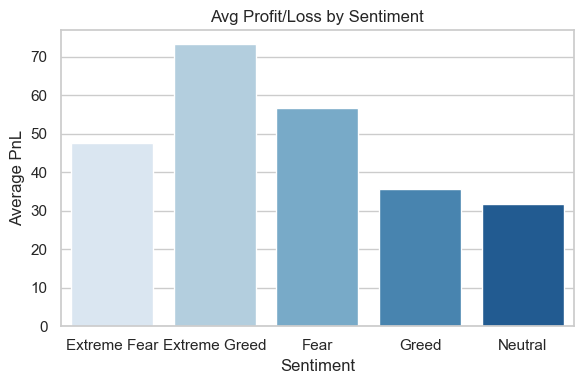

In [31]:
# Average Profit/Loss chart
plt.figure(figsize=(6,4))
sns.barplot(x='Sentiment', y='Closed PnL', data=avg_pnl, palette='Blues')
plt.title('Avg Profit/Loss by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Average PnL')
plt.tight_layout()
plt.show()

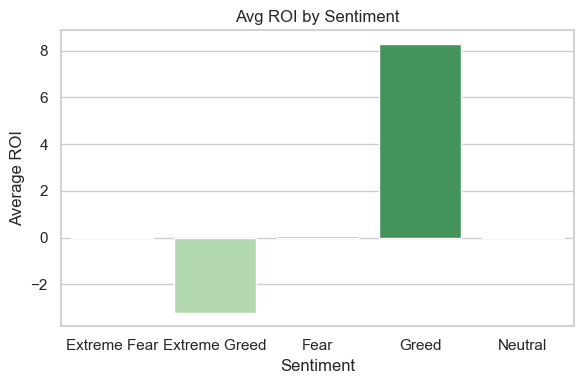

In [32]:
# Average ROI chart
plt.figure(figsize=(6,4))
sns.barplot(x='Sentiment', y='ROI', data=avg_roi, palette='Greens')
plt.title('Avg ROI by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Average ROI')
plt.tight_layout()
plt.show()

In [33]:
# Find Top Traders
trader_summary = merged_df.groupby(['Account', 'Sentiment']).agg(
    total_trades=('Account', 'count'),
    avg_roi = ('ROI','mean'),
    win_rate = ('win', 'mean')
).reset_index()

In [37]:
# Get top 3 sentiment 
top_traders = trader_summary.sort_values(['Sentiment', 'avg_roi'],ascending=[True, False]) \
.groupby('Sentiment').head(3)

In [38]:
print(top_traders)

                                        Account      Sentiment  total_trades  \
19   0x2c229d22b100a7beb69122eed721cee9b24011dd   Extreme Fear            36   
80   0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4   Extreme Fear            86   
90   0x8170715b3b381dffb7062c0298972d4727a0a63b   Extreme Fear            93   
114  0xa520ded057a32086c40e7dd6ed4eb8efb82c00e0  Extreme Greed           133   
41   0x430f09841d65beb3f27765503d0f850b8bce7713  Extreme Greed            18   
10   0x271b280974205ca63b716753467d5a371de622ab  Extreme Greed             1   
115  0xa520ded057a32086c40e7dd6ed4eb8efb82c00e0           Fear           108   
77   0x72c6a4624e1dffa724e6d00d64ceae698af892a0           Fear           460   
82   0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4           Fear          1725   
26   0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891          Greed           132   
146  0xbee1707d6b44d4d52bfe19e41f8a828645437aab          Greed          6900   
120  0xae5eacaf9c6b9111fd53034a602c192a0